In [2]:
import logging
import os
from pathlib import Path
import random

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import torch
from torch.utils.data import DataLoader,TensorDataset

# import wandb


In [3]:
#################
# Login to wandb
# wandb.login()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ["WANDB_PROJECT"]="few-shot-mbert"

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
torch.cuda.device(0)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1234)

NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
# Run predictions
def gen_predictions(test_loader, model):
    all_predictions = []
    with torch.no_grad():  
        for batch in test_loader:
            input_ids, attention_mask = [tensor.to(device) for tensor in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
    return all_predictions

In [4]:
import pandas as pd
test_df_path = '/zpool/aurora-main/scratch/vera/actdisease-genre/results/zero_shot.dev.csv'
test_df=pd.read_csv(test_df_path, index_col=0)

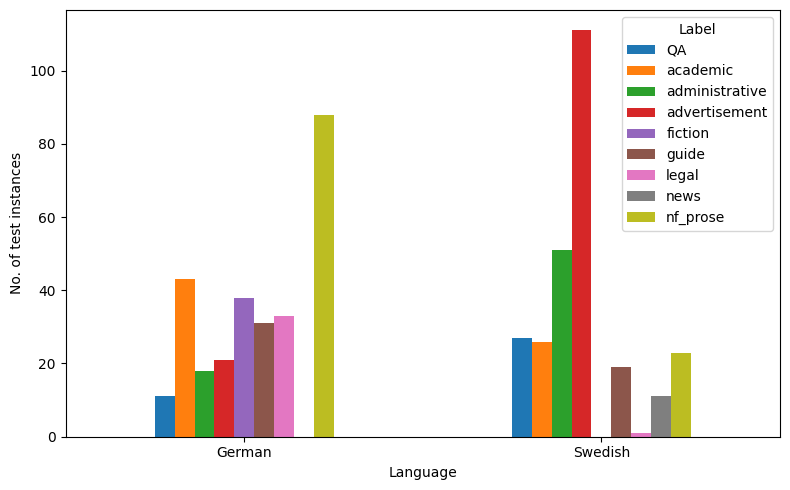

In [10]:
test_df_path = '/zpool/aurora-main/scratch/vera/actdisease-genre/zero_shot.dev.csv'
test_df=pd.read_csv(test_df_path, index_col=0)

# Replace the 'language' column with the mapped full language names
language_map = {
    'swe': 'Swedish',
    'deu': 'German'
}
test_df['language'] = test_df['language'].map(language_map)
test_df['label']=test_df.label.replace({'non_fiction': 'nf_prose'})


# plot distribution of instances in languages and genres
grouped_data = test_df.groupby(['language', 'label']).size().unstack()
grouped_data.plot(kind='bar', figsize=(8, 5), stacked=False)

plt.xlabel('Language')
plt.ylabel('No. of test instances')
# plt.title('Comparison of Label Sizes by Language')
plt.xticks(rotation=0)
plt.legend(title='Label')

plt.tight_layout()
plt.show()

In [6]:
test_df.label.value_counts()

label
non_fiction       111
academic           69
administrative     69
guide              50
QA                 38
fiction            38
legal              34
news               11
Name: count, dtype: int64

In [11]:
def plot_cms(y_true, y_pred, dir, class_label):

    dir_name  = 'plots_zero_shot'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name) 
    sns.set_palette("pastel") 
    cm = sklearn.metrics.confusion_matrix(y_true,
                        y_pred)
    class_label = ['nf_prose' if label == 'nonfiction' or label == 'non_fiction' else label for label in class_label]
    cm_df = pd.DataFrame(cm, index = class_label, columns = class_label)
    plt.figure(figsize = (7,5))
    g = sns.heatmap(cm_df, cmap = 'Blues', annot=True, fmt='g', annot_kws={"size": 10})
    g.xaxis.set_ticks_position("top")
    g.tick_params(axis='x', rotation=55)
    g.set_xlabel("Predicted Genre")
    g.set_ylabel("True Genre")
    info = dir.split('__')
    plt.title(info[0]+'__'+info[1]+'__'+info[2]+'__'+info[6])
    plt.tight_layout()
    
    plt.savefig(os.path.join(dir_name, dir), dpi=300)

In [12]:
test_df_path = '/zpool/aurora-main/scratch/vera/actdisease-genre/zero_shot.dev.csv'
test_df=pd.read_csv(test_df_path, index_col=0)

# FTD
# test_df=test_df.query("label not in ['administrative','QA']")
# data_dir = '/zpool/aurora-main/scratch/vera/actdisease-genre/finetuned-models-FTD'


# UDM
# data_dir = '/zpool/aurora-main/scratch/vera/actdisease-genre/finetuned-models-UDM'
# test_df=test_df.query("label not in ['advertisement']")

#CORE
data_dir = '/zpool/aurora-main/scratch/vera/actdisease-genre/finetuned-models-CORE'
test_df=test_df.query("label not in ['administrative']")

#all
# data_dir = '/zpool/aurora-main/scratch/vera/actdisease-genre/finetuned-models-all'



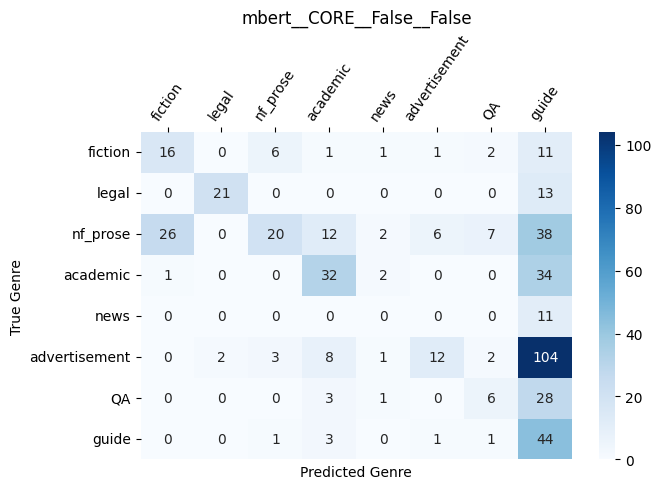

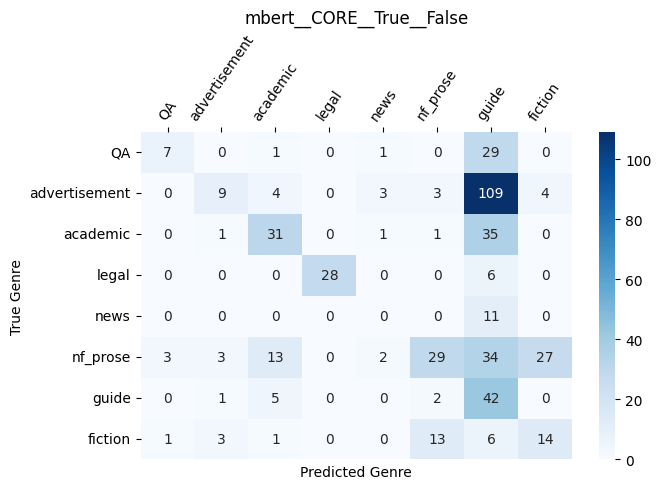

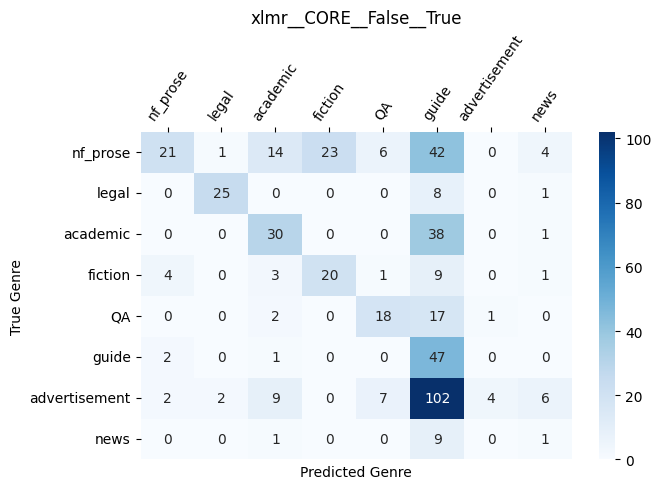

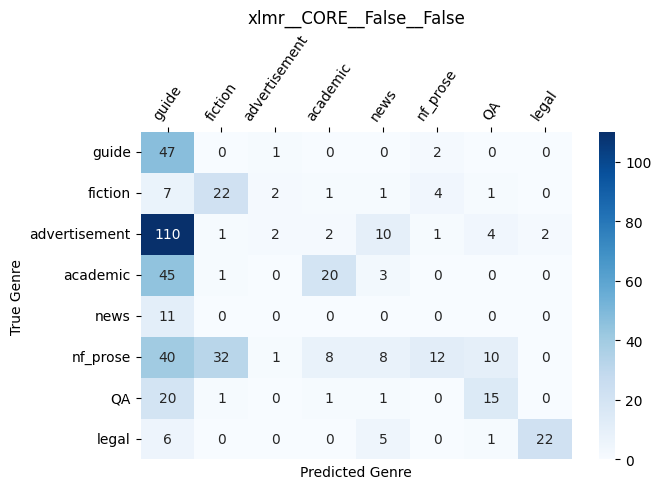

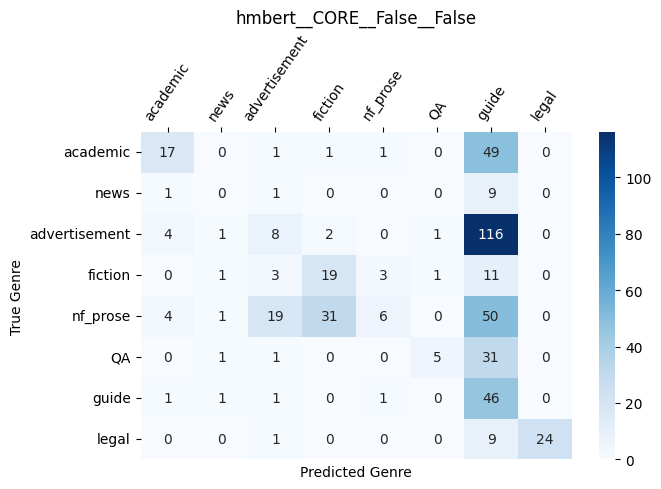

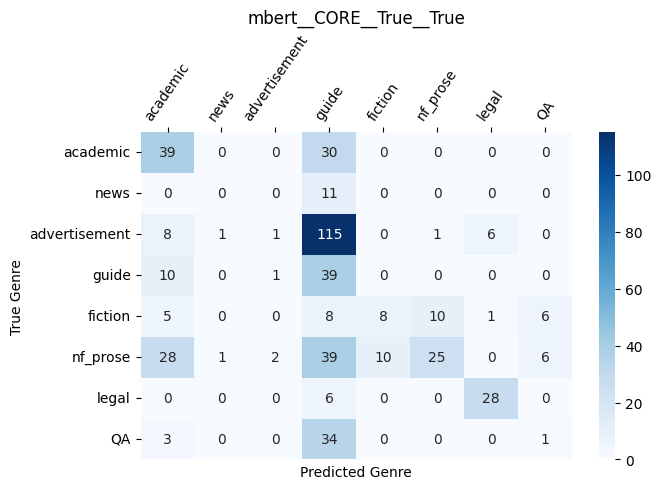

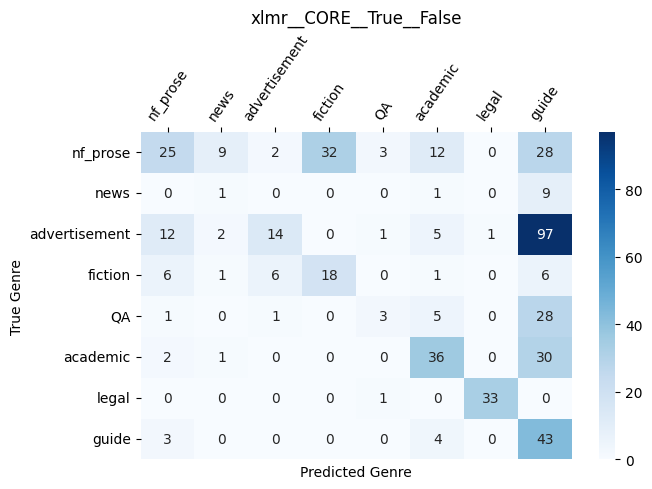

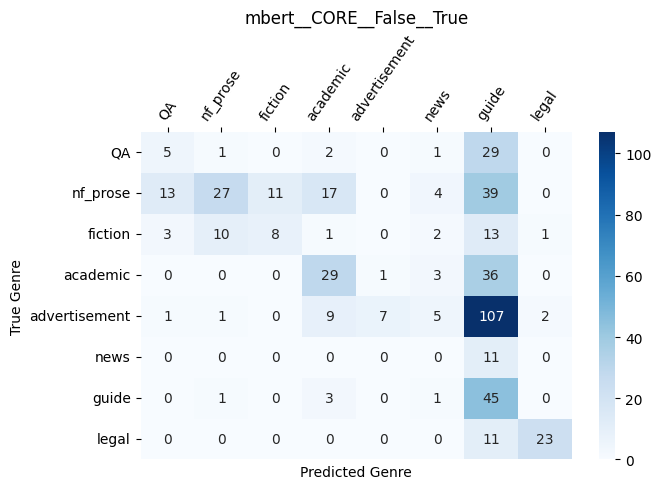

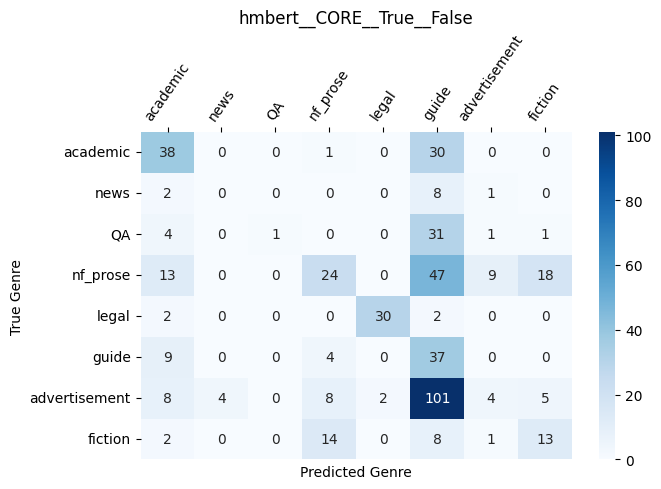

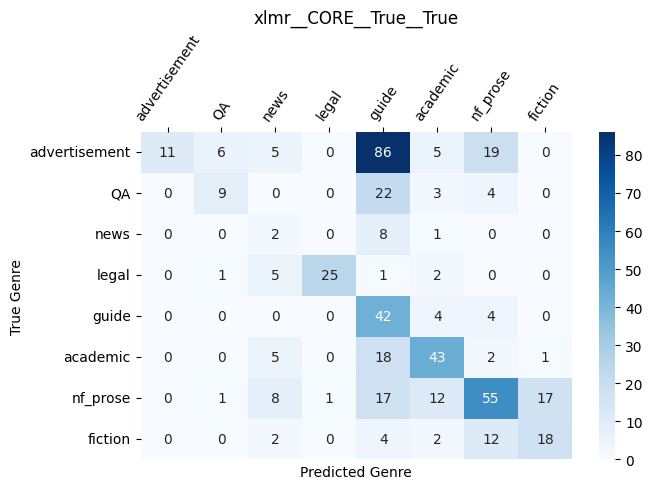

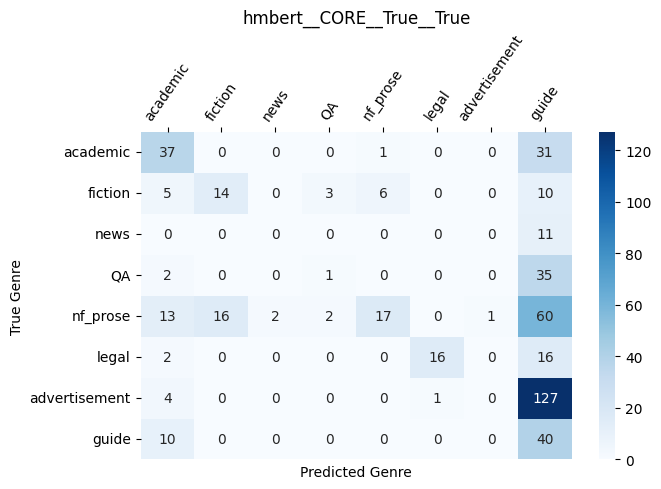

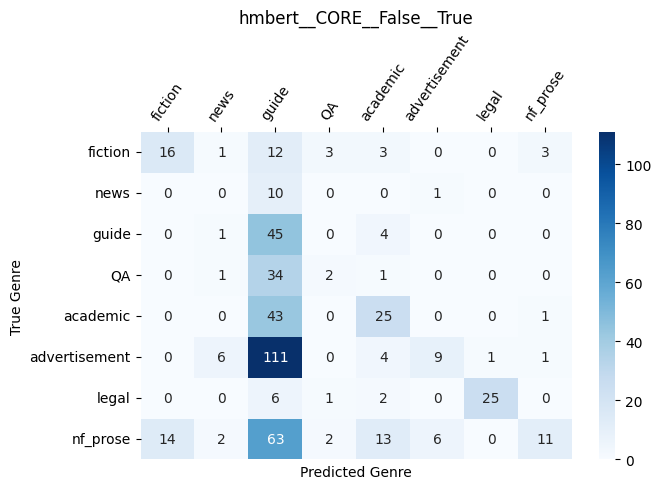

In [ ]:
# dfs=[]
results=[]


for n, dir in enumerate(os.listdir(data_dir)):
    if Path(os.path.join(data_dir,dir)).is_dir():
        path_to_folder=os.path.join(data_dir,dir)
        for file in os.listdir(path_to_folder):
            if file.startswith('checkpoint'):
                model_path=os.path.join(path_to_folder,file)
                model = AutoModelForSequenceClassification.from_pretrained(model_path)
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model.to(device)
                model.eval()
                def tokenize(texts):
                    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
                inputs = tokenize(test_df['text'].tolist())
                dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
                test_loader = DataLoader(dataset, batch_size=8)
                all_preds=gen_predictions(test_loader, model)
                test_df['pred']=all_preds
                assert len(all_preds) == len(test_df)
                test_df['label']=test_df.label.apply(lambda l: 'nonfiction' if l == "non_fiction" else l)
                # model_labels = list(model.config.label2id.keys())
                # test_df=test_df.query('label in @model_labels')

                y_true = test_df.label
                y_pred = test_df.pred
                y_true = [model.config.label2id[l] for l in y_true]
                
                
                class_label = list(model.config.id2label.values())

                plot_cms(y_true, y_pred, dir, class_label)
                
                # balanced_acc = balanced_accuracy_score(y_true, y_pred)
                # print(f"Balanced Accuracy: {balanced_acc:.2f}")

                id2label = model.config.id2label
                settings = dir.split('__')
                report = classification_report(y_true, y_pred, output_dict=True)
                f_measure_per_class = {id2label[int(key)]: value['f1-score'] for key, value in report.items() if key.isdigit()}
                # # f_per_class = list(map(itemgetter(1), sorted_by_genre))
                
                average_metrics = {
                'accuracy': report['accuracy'],
                'macro_F1': report['macro avg']['f1-score'],
                'weighted_F1': report['weighted avg']['f1-score']}

                print(average_metrics)
                
                labels_sorted = sorted(test_df.label.unique())
                
                f_per_class = [f_measure_per_class[g] for g in labels_sorted]

                # f_per_class = [
                # f_measure_per_class['QA'],
                # f_measure_per_class['academic'],
                # f_measure_per_class['administrative'],
                # f_measure_per_class['advertisement'],
                # f_measure_per_class['fiction'],
                # f_measure_per_class['guide'],
                # f_measure_per_class['legal'],
                # f_measure_per_class['news'],
                # f_measure_per_class['nonfiction']]
                
                results+=[(settings+f_per_class+[average_metrics['accuracy'],average_metrics['macro_F1'],average_metrics['weighted_F1']])]

## all

In [15]:
all_results = pd.DataFrame(results,columns=['model',
                              'dataset',
                              'germaniconly',
                              'genre_map',
                              'chunked',
                              'withpunkt',
                              'balanced',
                              'QA',
                              'academic',
                              'administrative',
                              'advertisement',
                              'fiction',
                              'guide',
                              'legal',
                              'news',
                              'nonfiction',
                              'accuracy',
                              'macro_F1',
                              'weighted_F1'])

ValueError: 19 columns passed, passed data had 18 columns

In [74]:
all_results.to_csv('all_results.csv')

In [75]:
cols=[
    'QA',
    'academic',
    'administrative',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',
    'accuracy',
    'macro_F1',
    'weighted_F1']

In [166]:
print(all_results.groupby('model')[['QA',
    'academic',
    'administrative',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',]].mean().round(2).T.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
model & hmbert & mbert & xlmr \\
\midrule
QA & 0.10 & 0.05 & 0.43 \\
academic & 0.18 & 0.15 & 0.27 \\
administrative & 0.24 & 0.18 & 0.14 \\
advertisement & 0.22 & 0.23 & 0.34 \\
fiction & 0.36 & 0.19 & 0.40 \\
guide & 0.18 & 0.17 & 0.28 \\
legal & 0.19 & 0.21 & 0.45 \\
news & 0.01 & 0.02 & 0.04 \\
nonfiction & 0.17 & 0.09 & 0.14 \\
\bottomrule
\end{tabular}



In [84]:
all_results.macro_F1.mean(), all_results.weighted_F1.mean()

(0.20145369310094982, 0.2104335561734292)

In [170]:
print(all_results.groupby(['model','germaniconly','balanced'])[cols].mean()\
      .sort_values(by='macro_F1', ascending=False)
      .to_markdown())

|                              |   academic |   advertisement |   fiction |    guide |     legal |       news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------------------------|-----------:|----------------:|----------:|---------:|----------:|-----------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'True', 'True')     |  0.261682  |       0.502793  |  0.337349 | 0.36     | 0.675676  | 0.0414508  |    0.227848  |  0.320652  |   0.351916 |      0.362918 |
| ('xlmr', 'False', 'True')    |  0.382979  |       0.465116  |  0.422535 | 0.289655 | 0.294737  | 0.038835   |    0.164179  |  0.269928  |   0.290655 |      0.307539 |
| ('xlmr', 'False', 'False')   |  0.306569  |       0.0869565 |  0.470588 | 0.241379 | 0.55914   | 0.0287081  |    0.0689655 |  0.213768  |   0.251168 |      0.202792 |
| ('xlmr', 'True', 'False_')   |  0.122449  |       0.316456  |  0.373626 | 0.24186  | 0.266667  | 0.033195   |    0.115702  |  0.192029  |   0.214765 |   

In [167]:
print(all_results.groupby(['model','germaniconly','balanced'])[cols].mean()\
      .sort_values(by='macro_F1', ascending=False)
      .to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrrrrrrrr}
\toprule
 &  &  & academic & advertisement & fiction & guide & legal & news & nonfiction & accuracy & macro_F1 & weighted_F1 \\
model & germaniconly & balanced &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{xlmr} & True & True & 0.26 & 0.50 & 0.34 & 0.36 & 0.68 & 0.04 & 0.23 & 0.32 & 0.35 & 0.36 \\
\cline{2-13}
 & \multirow[t]{2}{*}{False} & True & 0.38 & 0.47 & 0.42 & 0.29 & 0.29 & 0.04 & 0.16 & 0.27 & 0.29 & 0.31 \\
 &  & False & 0.31 & 0.09 & 0.47 & 0.24 & 0.56 & 0.03 & 0.07 & 0.21 & 0.25 & 0.20 \\
\cline{2-13}
 & True & False_ & 0.12 & 0.32 & 0.37 & 0.24 & 0.27 & 0.03 & 0.12 & 0.19 & 0.21 & 0.22 \\
\cline{1-13} \cline{2-13}
\multirow[t]{2}{*}{hmbert} & False & True & 0.25 & 0.03 & 0.43 & 0.17 & 0.25 & 0.01 & 0.37 & 0.19 & 0.21 & 0.21 \\
\cline{2-13}
 & True & True & 0.26 & 0.42 & 0.29 & 0.20 & 0.08 & 0.02 & 0.15 & 0.19 & 0.19 & 0.25 \\
\cline{1-13} \cline{2-13}
mbert & False & True & 0.25 & 0.22 & 0.27 & 0.19 & 0.15 & 0.05 & 0.21 & 0.17 

In [169]:
print(all_results.groupby(['model','balanced'])[cols].mean()\
      .sort_values(by='macro_F1', ascending=False)
      .to_markdown())

|                     |   academic |   advertisement |   fiction |    guide |    legal |       news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------------------|-----------:|----------------:|----------:|---------:|---------:|-----------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'True')    |  0.32233   |       0.483955  |  0.379942 | 0.324828 | 0.485206 | 0.0401429  |    0.196014  |   0.29529  |   0.321285 |      0.335229 |
| ('xlmr', 'False')   |  0.306569  |       0.0869565 |  0.470588 | 0.241379 | 0.55914  | 0.0287081  |    0.0689655 |   0.213768 |   0.251168 |      0.202792 |
| ('xlmr', 'False_')  |  0.122449  |       0.316456  |  0.373626 | 0.24186  | 0.266667 | 0.033195   |    0.115702  |   0.192029 |   0.214765 |      0.220782 |
| ('hmbert', 'True')  |  0.254032  |       0.222907  |  0.35619  | 0.184022 | 0.162736 | 0.0135323  |    0.260159  |   0.192029 |   0.201801 |      0.228896 |
| ('mbert', 'True')   |  0.179267  |       0.2

In [168]:
print(all_results.groupby(['model','balanced'])[cols].mean()\
      .sort_values(by='macro_F1', ascending=False)
      .to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & academic & advertisement & fiction & guide & legal & news & nonfiction & accuracy & macro_F1 & weighted_F1 \\
model & balanced &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{xlmr} & True & 0.32 & 0.48 & 0.38 & 0.32 & 0.49 & 0.04 & 0.20 & 0.30 & 0.32 & 0.34 \\
 & False & 0.31 & 0.09 & 0.47 & 0.24 & 0.56 & 0.03 & 0.07 & 0.21 & 0.25 & 0.20 \\
 & False_ & 0.12 & 0.32 & 0.37 & 0.24 & 0.27 & 0.03 & 0.12 & 0.19 & 0.21 & 0.22 \\
\cline{1-12}
hmbert & True & 0.25 & 0.22 & 0.36 & 0.18 & 0.16 & 0.01 & 0.26 & 0.19 & 0.20 & 0.23 \\
\cline{1-12}
mbert & True & 0.18 & 0.28 & 0.20 & 0.19 & 0.20 & 0.04 & 0.13 & 0.16 & 0.17 & 0.20 \\
\cline{1-12}
hmbert & False & 0.10 & 0.21 & 0.36 & 0.17 & 0.22 & 0.01 & 0.08 & 0.15 & 0.16 & 0.17 \\
\cline{1-12}
mbert & False & 0.13 & 0.18 & 0.18 & 0.15 & 0.22 & 0.00 & 0.04 & 0.10 & 0.12 & 0.12 \\
\cline{1-12}
\bottomrule
\end{tabular}



In [78]:
print(all_results.groupby(['germaniconly'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| germaniconly   |       QA |   academic |   administrative |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:---------------|---------:|-----------:|-----------------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| True           | 0.186746 |   0.16324  |         0.271252 |        0.33138  |  0.269605 | 0.217555 | 0.249725 | 0.0234106 |     0.102351 |   0.186292 |   0.201696 |      0.221106 |
| False          | 0.202057 |   0.234655 |         0.109722 |        0.192931 |  0.361888 | 0.204888 | 0.314545 | 0.0244336 |     0.165781 |   0.183273 |   0.201211 |      0.199761 |


In [79]:
print(all_results.groupby(['balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| balanced   |       QA |   academic |   administrative |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------|---------:|-----------:|-----------------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| True       | 0.231697 |   0.251877 |         0.220133 |        0.328916 |  0.311461 | 0.233838 | 0.282557 | 0.0318622 |    0.195946  |   0.216787 |   0.232032 |      0.253668 |
| False_     | 0.285714 |   0.122449 |         0.177215 |        0.316456 |  0.373626 | 0.24186  | 0.266667 | 0.033195  |    0.115702  |   0.192029 |   0.214765 |      0.220782 |
| False      | 0.131385 |   0.150733 |         0.157565 |        0.171183 |  0.309314 | 0.177955 | 0.284721 | 0.0125394 |    0.0634825 |   0.144928 |   0.162098 |      0.156482 |


In [80]:
print(all_results.groupby(['model'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| model   |        QA |   academic |   administrative |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------|----------:|-----------:|-----------------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| xlmr    | 0.425192  |   0.26842  |         0.144668 |        0.34283  |  0.401025 | 0.283224 | 0.449055 | 0.0355472 |    0.144174  |   0.249094 |   0.277126 |      0.273508 |
| hmbert  | 0.103896  |   0.175576 |         0.243175 |        0.215991 |  0.356855 | 0.17826  | 0.189404 | 0.0134966 |    0.170675  |   0.171649 |   0.183036 |      0.198115 |
| mbert   | 0.0541166 |   0.152847 |         0.183618 |        0.227646 |  0.189361 | 0.172182 | 0.207946 | 0.0227225 |    0.0873495 |   0.133605 |   0.144199 |      0.159678 |


In [82]:
print(all_results.sort_values(by='macro_F1', ascending=False).to_markdown())

|    | model   | dataset   | germaniconly   |   genre_map | chunked   | withpunkt   | balanced   |        QA |   academic |   administrative |   advertisement |   fiction |    guide |     legal |       news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|:----------|:---------------|------------:|:----------|:------------|:-----------|----------:|-----------:|-----------------:|----------------:|----------:|---------:|----------:|-----------:|-------------:|-----------:|-----------:|--------------:|
|  4 | xlmr    | all       | True           |           4 | True      | True        | True       | 0.519481  |  0.261682  |        0.240964  |       0.502793  |  0.337349 | 0.36     | 0.675676  | 0.0414508  |    0.227848  |  0.320652  |   0.351916 |      0.362918 |
|  5 | xlmr    | all       | False          |           4 | True      | True        | True       | 0.508475  |  0.382979  |        0.0493827 |       0.465116  |  0.422535 | 0.289655 | 0.294737  | 0.0388

## prediction with XGENRE

In [65]:
test_df_path = '/zpool/aurora-main/scratch/vera/actdisease-genre/zero_shot.dev.csv'
test_df=pd.read_csv(test_df_path, index_col=0)

model = AutoModelForSequenceClassification.from_pretrained('classla/xlm-roberta-base-multilingual-text-genre-classifier')
tokenizer = AutoTokenizer.from_pretrained('classla/xlm-roberta-base-multilingual-text-genre-classifier')
model.to(device)
model.eval()
def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
inputs = tokenize(test_df['text'].tolist())
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
test_loader = DataLoader(dataset, batch_size=8)
all_preds=gen_predictions(test_loader, model)

/home/vera/act-genre/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [66]:
all_preds = [model.config.id2label[i] for i in all_preds]

In [67]:
# label2label={
# 'Other': None,
# 'Information/Explanation': None,
# 'News': 'news',
# 'Instruction': 'guide',
# 'Opinion/Argumentation': None,
# 'Forum': None,
# 'Prose/Lyrical': 'fiction',
# 'Legal': 'legal',
# 'Promotion': 'advertisement'
# }

#test
# label2label={
# 'Other': 'Other',
# 'Information/Explanation': 'academic',
# 'News': 'news',
# 'Instruction': 'guide',
# 'Opinion/Argumentation': 'nonfiction',
# 'Forum': 'QA',
# 'Prose/Lyrical': 'fiction',
# 'Legal': 'legal',
# 'Promotion': 'advertisement'
# }


In [68]:
all_preds = [label2label[i] for i in all_preds]

In [69]:
test_df['pred']=all_preds

In [39]:
test_df = test_df.dropna()


In [45]:
test_df.pred.unique()

array(['legal', 'academic', 'news', 'advertisement', 'guide',
       'nonfiction', 'fiction', 'QA'], dtype=object)

In [70]:
y_true = test_df.label
y_pred = test_df.pred
report = classification_report(y_true, y_pred, output_dict=True)


/home/vera/act-genre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vera/act-genre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vera/act-genre/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vera/act-genre/lib/py

In [64]:
results=[]
f_measure_per_class = {key: value['f1-score'] for key, value in report.items() if type(value) == dict}
average_metrics = {
'accuracy': report['accuracy'],
'macro_F1': report['macro avg']['f1-score'],
'weighted_F1': report['weighted avg']['f1-score']}
f_per_class=[
f_measure_per_class['advertisement'],
f_measure_per_class['academic'],
f_measure_per_class['nonfiction'],
f_measure_per_class['QA'],
f_measure_per_class['fiction'],
f_measure_per_class['guide'],
f_measure_per_class['legal'],
f_measure_per_class['news'],
]
results=[['XGENRE']+f_per_class+[average_metrics['accuracy'],average_metrics['macro_F1'],average_metrics['weighted_F1']]]
print(pd.DataFrame(results, columns=['model',
                               'advertisement',
                               'academic',
                               'nonfiction',
                               'QA',
                               'fiction',
                               'guide',
                               'legal',
                               'news',
                               'accuracy',
                               'macro_F1',
                               'weighted_F1']).to_markdown())

|    | model   |   advertisement |   academic |   nonfiction |      QA |   fiction |    guide |    legal |      news |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|----------------:|-----------:|-------------:|--------:|----------:|---------:|---------:|----------:|-----------:|-----------:|--------------:|
|  0 | XGENRE  |        0.693694 |   0.466667 |            0 | 0.40678 |  0.393939 | 0.597701 | 0.666667 | 0.0869565 |   0.371377 |   0.301128 |      0.376274 |


In [33]:
f_measure_per_class = {key: value['f1-score'] for key, value in report.items() if type(value) == dict}
average_metrics = {
'accuracy': report['accuracy'],
'macro_F1': report['macro avg']['f1-score'],
'weighted_F1': report['weighted avg']['f1-score']}
f_per_class=[
f_measure_per_class['advertisement'],
f_measure_per_class['fiction'],
f_measure_per_class['guide'],
f_measure_per_class['legal'],
f_measure_per_class['news'],
]
results=[(['XGENRE']+f_per_class+[average_metrics['accuracy'],average_metrics['macro_F1'],average_metrics['weighted_F1']])]
print(pd.DataFrame(results, columns=['model',
                               'advertisement',
                               'fiction',
                               'guide',
                               'legal',
                               'news',
                               'accuracy',
                               'macro_F1',
                               'weighted_F1']).to_markdown())

|    | model   |   advertisement |   fiction |   guide |    legal |      news |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|----------------:|----------:|--------:|---------:|----------:|-----------:|-----------:|--------------:|
|  0 | XGENRE  |        0.890173 |  0.604651 |  0.8125 | 0.947368 | 0.0952381 |   0.587983 |   0.372215 |       0.52541 |


## FTD

In [4]:
# ['academic', 'advertisement', 'fiction', 'guide', 'legal', 'news', 'nonfiction']
FTD_results = pd.DataFrame(results,columns=['model',
                              'dataset',
                              'germaniconly',
                              'genre_map',
                              'chunked',
                              'withpunkt',
                              'balanced',
                              'academic',
                              'advertisement',
                              'fiction',
                              'guide',
                              'legal',
                              'news',
                              'nonfiction',
                              'accuracy',
                              'macro_F1',
                              'weighted_F1'])

In [146]:
FTD_results.to_csv('FTD_results.csv')

In [5]:
cols=[
    'academic',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',
    'accuracy',
    'macro_F1',
    'weighted_F1']

In [6]:
print(FTD_results.groupby('model')[['academic',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction']].mean().round(2).T.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
model & hmbert & mbert & xlmr \\
\midrule
academic & 0.37 & 0.61 & 0.57 \\
advertisement & 0.56 & 0.62 & 0.74 \\
fiction & 0.43 & 0.40 & 0.49 \\
guide & 0.33 & 0.47 & 0.57 \\
legal & 0.90 & 0.82 & 0.89 \\
news & 0.38 & 0.34 & 0.28 \\
nonfiction & 0.47 & 0.54 & 0.56 \\
\bottomrule
\end{tabular}



In [7]:
FTD_results.macro_F1.mean(), FTD_results.weighted_F1.mean()

(0.5404964399683635, 0.5646076970135515)

In [8]:
FTD_results.macro_F1.max(), FTD_results.weighted_F1.max()

(0.6156005884692517, 0.6847880805797175)

In [9]:
print(FTD_results.sort_values(by='macro_F1', ascending=False).to_markdown())

|    | model   | dataset   | germaniconly   |   genre_map | chunked   | withpunkt   | balanced   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|:----------|:---------------|------------:|:----------|:------------|:-----------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
|  6 | xlmr    | FTD       | False          |           4 | True      | True        | False      |   0.583333 |        0.837209 |  0.452381 | 0.712871 | 0.882353 | 0.222222 |     0.618834 |   0.676404 |   0.615601 |      0.684788 |
|  3 | mbert   | FTD       | False          |           4 | True      | True        | False      |   0.715152 |        0.772201 |  0.430108 | 0.469136 | 0.901408 | 0.363636 |     0.582915 |   0.65618  |   0.604936 |      0.652648 |
|  0 | mbert   | FTD       | True           |           4 | True      | 

In [89]:
print(FTD_results.groupby(['model','germaniconly','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                              |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------------------------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| ('mbert', 'False', 'False')  |   0.715152 |        0.772201 |  0.430108 | 0.469136 | 0.901408 | 0.363636 |     0.582915 |   0.65618  |   0.604936 |      0.652648 |
| ('mbert', 'True', 'False')   |   0.671642 |        0.684211 |  0.414634 | 0.54717  | 0.852459 | 0.388889 |     0.584362 |   0.613483 |   0.591909 |      0.624493 |
| ('xlmr', 'False', 'True')    |   0.618421 |        0.621005 |  0.538462 | 0.5625   | 0.865672 | 0.342857 |     0.540284 |   0.593258 |   0.584171 |      0.598665 |
| ('xlmr', 'True', 'False')    |   0.574074 |        0.778243 |  0.493827 | 0.52381  | 0.892308 | 0.25     |     0.507614 |   0.608989 |   0.574268 |      0.621862 |
| ('

In [10]:
print(FTD_results.groupby(['model','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                     |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------------------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| ('mbert', 'False')  |   0.693397 |        0.728206 |  0.422371 | 0.508153 | 0.876934 | 0.376263 |     0.583638 |   0.634831 |   0.598423 |      0.63857  |
| ('xlmr', 'False')   |   0.578704 |        0.807726 |  0.473104 | 0.61834  | 0.88733  | 0.236111 |     0.563224 |   0.642697 |   0.594934 |      0.653325 |
| ('xlmr', 'True')    |   0.559211 |        0.675309 |  0.505342 | 0.517275 | 0.893153 | 0.314286 |     0.553161 |   0.593258 |   0.573962 |      0.602288 |
| ('hmbert', 'False') |   0.397689 |        0.636344 |  0.417308 | 0.323302 | 0.951613 | 0.374111 |     0.480101 |   0.525843 |   0.511495 |      0.524094 |
| ('mbert', 'True')   |   0.532939 |        0.509119 |  0.

| balanced   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| False      |   0.556596 |        0.724092 |  0.437594 | 0.483265 | 0.905292 | 0.328828 |     0.542321 |   0.601124 |   0.568284 |      0.60533  |
| True       |   0.47991  |        0.558265 |  0.446419 | 0.433296 | 0.835714 | 0.334433 |     0.500923 |   0.51573  |   0.512709 |      0.523886 |


| germaniconly   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:---------------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| False          |   0.52026  |        0.686527 |  0.447903 | 0.485286 | 0.886732 | 0.355126 |     0.5416   |   0.585393 |   0.560491 |      0.588712 |
| True           |   0.516247 |        0.59583  |  0.43611  | 0.431275 | 0.854274 | 0.308136 |     0.501645 |   0.531461 |   0.520502 |      0.540503 |


In [11]:
print(FTD_results.groupby(['balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| balanced   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| False      |   0.556596 |        0.724092 |  0.437594 | 0.483265 | 0.905292 | 0.328828 |     0.542321 |   0.601124 |   0.568284 |      0.60533  |
| True       |   0.47991  |        0.558265 |  0.446419 | 0.433296 | 0.835714 | 0.334433 |     0.500923 |   0.51573  |   0.512709 |      0.523886 |


In [12]:
print(FTD_results.groupby(['germaniconly'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| germaniconly   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:---------------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| False          |   0.52026  |        0.686527 |  0.447903 | 0.485286 | 0.886732 | 0.355126 |     0.5416   |   0.585393 |   0.560491 |      0.588712 |
| True           |   0.516247 |        0.59583  |  0.43611  | 0.431275 | 0.854274 | 0.308136 |     0.501645 |   0.531461 |   0.520502 |      0.540503 |


In [155]:
print(FTD_results.groupby(['model'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| model   |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| xlmr    |   0.568957 |        0.741518 |  0.489223 | 0.567808 | 0.890242 | 0.275198 |     0.558193 |   0.617978 |   0.584448 |      0.627807 |
| mbert   |   0.613168 |        0.618662 |  0.403285 | 0.47233  | 0.822395 | 0.336367 |     0.538538 |   0.566292 |   0.543535 |      0.571579 |
| hmbert  |   0.372635 |        0.563356 |  0.433512 | 0.334703 | 0.898872 | 0.383327 |     0.468136 |   0.491011 |   0.493506 |      0.494438 |


## CORE

In [15]:
CORE_results = pd.DataFrame(results,columns=['model',
                              'dataset',
                              'germaniconly',
                              'genre_map',
                              'chunked',
                              'withpunkt',
                              'balanced',
                              'QA',
                              'academic',
                              'advertisement',
                              'fiction',
                              'guide',
                              'legal',
                              'news',
                              'nonfiction',
                              'accuracy',
                              'macro_F1',
                              'weighted_F1'])

In [100]:
CORE_results.to_csv('CORE_results.csv')

In [16]:
cols=['QA',
    'academic',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',
    'accuracy',
    'macro_F1',
    'weighted_F1']

\begin{tabular}{lrrr}
\toprule
model & hmbert & mbert & xlmr \\
\midrule
QA & 0.10 & 0.18 & 0.35 \\
academic & 0.45 & 0.48 & 0.50 \\
advertisement & 0.07 & 0.10 & 0.11 \\
fiction & 0.41 & 0.32 & 0.46 \\
guide & 0.23 & 0.26 & 0.30 \\
legal & 0.80 & 0.80 & 0.84 \\
news & 0.00 & 0.00 & 0.07 \\
nonfiction & 0.20 & 0.34 & 0.33 \\
\bottomrule
\end{tabular}

In [17]:
print(CORE_results.groupby('model')[['QA',
    'academic',
    'advertisement',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction']].mean().round(2).T.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
model & hmbert & mbert & xlmr \\
\midrule
QA & 0.10 & 0.18 & 0.35 \\
academic & 0.45 & 0.48 & 0.50 \\
advertisement & 0.07 & 0.10 & 0.11 \\
fiction & 0.41 & 0.32 & 0.46 \\
guide & 0.23 & 0.26 & 0.30 \\
legal & 0.80 & 0.80 & 0.84 \\
news & 0.00 & 0.00 & 0.07 \\
nonfiction & 0.20 & 0.34 & 0.33 \\
\bottomrule
\end{tabular}



In [18]:
# (0.3214394989958116, 0.2932457940404631)
CORE_results.macro_F1.mean(), CORE_results.weighted_F1.mean()

(0.3214394989958116, 0.2932457940404631)

In [103]:
CORE_results.macro_F1.max(), CORE_results.weighted_F1.max()

(0.42328019755631896, 0.4114448612857995)

In [19]:
print(CORE_results.sort_values(by='macro_F1', ascending=False).to_markdown())

|    | model   | dataset   | germaniconly   |   genre_map | chunked   | withpunkt   | balanced   |        QA |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|:----------|:---------------|------------:|:----------|:------------|:-----------|----------:|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
|  9 | xlmr    | CORE      | True           |           4 | True      | True        | True       | 0.327273  |   0.609929 |       0.153846  |  0.486486 | 0.33871  | 0.833333 | 0.105263 |    0.531401  |   0.424431 |   0.42328  |      0.411445 |
|  2 | xlmr    | CORE      | False          |           4 | True      | True        | True       | 0.514286  |   0.465116 |       0.0583942 |  0.493827 | 0.291925 | 0.806452 | 0.08     |    0.3       |   0.343685 |   0.37625  |      0.319472 |
|  6 | xlmr    | CORE   

In [105]:
print(CORE_results.groupby(['model','germaniconly','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                              |        QA |   academic |   advertisement |   fiction |    guide |    legal |     news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------------------------|----------:|-----------:|----------------:|----------:|---------:|---------:|---------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'True', 'True')     | 0.327273  |   0.609929 |       0.153846  |  0.486486 | 0.33871  | 0.833333 | 0.105263 |    0.531401  |   0.424431 |   0.42328  |      0.411445 |
| ('xlmr', 'False', 'True')    | 0.514286  |   0.465116 |       0.0583942 |  0.493827 | 0.291925 | 0.806452 | 0.08     |    0.3       |   0.343685 |   0.37625  |      0.319472 |
| ('xlmr', 'True', 'False')    | 0.130435  |   0.541353 |       0.180645  |  0.409091 | 0.295533 | 0.970588 | 0.08     |    0.3125    |   0.358178 |   0.365018 |      0.341707 |
| ('mbert', 'True', 'False')   | 0.285714  |   0.5      |       0.120805  |  0.337349 | 0.26087  | 0.903226 | 

In [106]:
print(CORE_results.groupby(['model','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                     |        QA |   academic |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------------------|----------:|-----------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'True')    | 0.420779  |   0.537523 |       0.10612   |  0.490157 | 0.315318 | 0.819892 | 0.0926316 |     0.4157   |   0.384058 |   0.399765 |      0.365458 |
| ('xlmr', 'False')   | 0.282609  |   0.468696 |       0.104815  |  0.436124 | 0.287647 | 0.864604 | 0.04      |     0.248558 |   0.324017 |   0.341632 |      0.300821 |
| ('mbert', 'False')  | 0.25      |   0.5      |       0.13935   |  0.366206 | 0.262567 | 0.820034 | 0         |     0.324234 |   0.321946 |   0.332799 |      0.317411 |
| ('hmbert', 'False') | 0.136752  |   0.435587 |       0.0749312 |  0.382125 | 0.241824 | 0.868339 | 0         |     0.197328 |   0.281573 |   0.29211

In [107]:
print(CORE_results.groupby(['balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| balanced   |       QA |   academic |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------|---------:|-----------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| False      | 0.22312  |   0.468094 |       0.106366  |  0.394818 | 0.264013 | 0.850992 | 0.0133333 |     0.256707 |   0.309179 |   0.32218  |      0.291089 |
| True       | 0.196642 |   0.489505 |       0.0747613 |  0.404847 | 0.263445 | 0.779805 | 0.0308772 |     0.325706 |   0.31539  |   0.320699 |      0.295403 |


In [108]:
print(CORE_results.groupby(['germaniconly'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| germaniconly   |       QA |   academic |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:---------------|---------:|-----------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| True           | 0.146562 |   0.528483 |       0.0873428 |  0.379512 | 0.262708 | 0.842547 | 0.0308772 |     0.349494 |   0.328157 |   0.328441 |      0.308283 |
| False          | 0.2732   |   0.429117 |       0.0937841 |  0.420153 | 0.26475  | 0.78825  | 0.0133333 |     0.232918 |   0.296411 |   0.314438 |      0.278208 |


In [109]:
print(CORE_results.groupby(['model'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| model   |       QA |   academic |   advertisement |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------|---------:|-----------:|----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| xlmr    | 0.351694 |   0.50311  |       0.105468  |  0.463141 | 0.301482 | 0.842248 | 0.0663158 |     0.332129 |   0.354037 |   0.370698 |      0.33314  |
| mbert   | 0.176471 |   0.481909 |       0.0983515 |  0.324707 | 0.256001 | 0.804582 | 0         |     0.336555 |   0.308489 |   0.309822 |      0.295636 |
| hmbert  | 0.101479 |   0.451381 |       0.067871  |  0.411651 | 0.233704 | 0.799365 | 0         |     0.204934 |   0.274327 |   0.283798 |      0.250962 |


## UDM

In [21]:
UDM_results = pd.DataFrame(results,columns=['model',
                              'dataset',
                              'germaniconly',
                              'genre_map',
                              'chunked',
                              'withpunkt',
                              'balanced',
                              'QA',
                              'academic',
                              'administrative',
                              'fiction',
                              'guide',
                              'legal',
                              'news',
                              'nonfiction',
                              'accuracy',
                              'macro_F1',
                              'weighted_F1'])

In [112]:
UDM_results.to_csv('UDM_results.csv')

In [22]:
cols=['QA',
    'academic',
    'administrative',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',
    'accuracy',
    'macro_F1',
    'weighted_F1']

In [23]:
print(UDM_results.groupby('model')[['QA',
    'academic',
    'administrative',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction']].mean().T.round(2).to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
model & hmbert & mbert & xlmr \\
\midrule
QA & 0.10 & 0.16 & 0.53 \\
academic & 0.04 & 0.25 & 0.21 \\
administrative & 0.43 & 0.25 & 0.30 \\
fiction & 0.27 & 0.17 & 0.30 \\
guide & 0.26 & 0.29 & 0.31 \\
legal & 0.08 & 0.16 & 0.14 \\
news & 0.01 & 0.04 & 0.05 \\
nonfiction & 0.03 & 0.01 & 0.08 \\
\bottomrule
\end{tabular}



In [24]:
UDM_results.macro_F1.mean(), UDM_results.weighted_F1.mean()

(0.18702316464680668, 0.18376101933590402)

In [115]:
UDM_results.macro_F1.max(), UDM_results.weighted_F1.max()

(0.28077665579236866, 0.26283577831612853)

In [25]:
print(UDM_results.sort_values(by='macro_F1', ascending=False).to_markdown())

|    | model   | dataset   | germaniconly   |   genre_map | chunked   | withpunkt   | balanced   |        QA |   academic |   administrative |   fiction |    guide |     legal |       news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|---:|:--------|:----------|:---------------|------------:|:----------|:------------|:-----------|----------:|-----------:|-----------------:|----------:|---------:|----------:|-----------:|-------------:|-----------:|-----------:|--------------:|
|  5 | xlmr    | UDM       | False          |           4 | True      | True        | True       | 0.548387  |  0.378378  |         0.232558 | 0.453333  | 0.305085 | 0.262295  | 0.0661765  |    0         |  0.216667  |   0.280777 |      0.250286 |
|  6 | xlmr    | UDM       | False          |           4 | True      | True        | False      | 0.666667  |  0.27907   |         0.131579 | 0.384     | 0.178571 | 0.253968  | 0.071066   |    0.214286  |  0.242857  |   0.272401 |      0.262836 |
|  2 | m

In [128]:
print(UDM_results.groupby('model')[['QA',
    'academic',
    'administrative',
    'fiction',
    'guide',
    'legal',
    'news',
    'nonfiction',]].mean().to_markdown())

| model   |       QA |   academic |   administrative |   fiction |    guide |     legal |      news |   nonfiction |
|:--------|---------:|-----------:|-----------------:|----------:|---------:|----------:|----------:|-------------:|
| hmbert  | 0.098202 |   0.041683 |         0.431636 |  0.267381 | 0.262145 | 0.0814935 | 0.0117072 |   0.0308533  |
| mbert   | 0.163712 |   0.254166 |         0.252292 |  0.174428 | 0.294944 | 0.159265  | 0.0359653 |   0.00877193 |
| xlmr    | 0.532408 |   0.205466 |         0.302073 |  0.296722 | 0.306245 | 0.141886  | 0.0543106 |   0.0808006  |


In [117]:
print(UDM_results.groupby(['model','germaniconly','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                              |        QA |   academic |   administrative |   fiction |    guide |     legal |       news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------------------------|----------:|-----------:|-----------------:|----------:|---------:|----------:|-----------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'False', 'True')    | 0.548387  |  0.378378  |         0.232558 | 0.453333  | 0.305085 | 0.262295  | 0.0661765  |    0         |  0.216667  |   0.280777 |      0.250286 |
| ('xlmr', 'False', 'False')   | 0.666667  |  0.27907   |         0.131579 | 0.384     | 0.178571 | 0.253968  | 0.071066   |    0.214286  |  0.242857  |   0.272401 |      0.262836 |
| ('mbert', 'False', 'True')   | 0.235294  |  0.567164  |         0.272727 | 0.305556  | 0.225806 | 0.339623  | 0.0414508  |    0         |  0.233333  |   0.248453 |      0.242377 |
| ('mbert', 'False', 'False')  | 0.0930233 |  0.393162  |         0.148148 | 0.392157  | 0

In [61]:
print(UDM_results.groupby(['model','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                     |        QA |   academic |   administrative |   fiction |    guide |     legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------------------|----------:|-----------:|-----------------:|----------:|---------:|----------:|----------:|-------------:|-----------:|-----------:|--------------:|
| ('xlmr', 'True')    | 0.511482  |  0.230856  |         0.252643 |  0.371594 | 0.337158 | 0.156789  | 0.0630882 |    0.0202703 |   0.184524 |   0.242985 |      0.219169 |
| ('xlmr', 'False')   | 0.553333  |  0.180075  |         0.351504 |  0.221851 | 0.275332 | 0.126984  | 0.045533  |    0.141331  |   0.205952 |   0.236993 |      0.239068 |
| ('mbert', 'True')   | 0.19928   |  0.311751  |         0.27051  |  0.152778 | 0.281917 | 0.169811  | 0.0454932 |    0         |   0.160714 |   0.178943 |      0.17601  |
| ('mbert', 'False')  | 0.128144  |  0.196581  |         0.234074 |  0.196078 | 0.307971 | 0.148718  | 0.0264374 |    0.0175439 |   0.136905

In [118]:
print(UDM_results.groupby(['balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| balanced   |       QA |   academic |   administrative |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-----------|---------:|-----------:|-----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| True       | 0.286303 |   0.185631 |         0.31541  |  0.260394 | 0.30062  | 0.120771 | 0.041332  |    0.0153352 |   0.161905 |   0.190725 |      0.182477 |
| False      | 0.243244 |   0.148579 |         0.341924 |  0.23196  | 0.274936 | 0.134325 | 0.0266568 |    0.0649487 |   0.162698 |   0.183322 |      0.185045 |


In [119]:
print(UDM_results.groupby(['germaniconly','balanced'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

|                    |       QA |   academic |   administrative |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:-------------------|---------:|-----------:|-----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| ('False', 'True')  | 0.359993 |  0.315181  |         0.283813 | 0.373445  | 0.255395 | 0.224449 | 0.0435681 |   0.00595238 |   0.196825 |   0.232724 |      0.216053 |
| ('False', 'False') | 0.268734 |  0.233601  |         0.242003 | 0.366827  | 0.251553 | 0.251556 | 0.0319718 |   0.107105   |   0.194444 |   0.219169 |      0.215093 |
| ('True', 'True')   | 0.212614 |  0.0560809 |         0.347007 | 0.147343  | 0.345845 | 0.017094 | 0.0390958 |   0.024718   |   0.126984 |   0.148725 |      0.148901 |
| ('True', 'False')  | 0.217755 |  0.0635567 |         0.441846 | 0.0970935 | 0.298319 | 0.017094 | 0.0213417 |   0.022792   |   0.130952 |   0.147475 |   

In [120]:
print(UDM_results.groupby(['germaniconly'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| germaniconly   |       QA |   academic |   administrative |   fiction |    guide |    legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:---------------|---------:|-----------:|-----------------:|----------:|---------:|---------:|----------:|-------------:|-----------:|-----------:|--------------:|
| False          | 0.314363 |  0.274391  |         0.262908 |  0.370136 | 0.253474 | 0.238002 | 0.03777   |    0.0565288 |   0.195635 |   0.225947 |      0.215573 |
| True           | 0.215184 |  0.0598188 |         0.394426 |  0.122218 | 0.322082 | 0.017094 | 0.0302188 |    0.023755  |   0.128968 |   0.1481   |      0.151949 |


In [121]:
print(UDM_results.groupby(['model'])[cols].mean().sort_values(by='macro_F1', ascending=False).to_markdown())

| model   |       QA |   academic |   administrative |   fiction |    guide |     legal |      news |   nonfiction |   accuracy |   macro_F1 |   weighted_F1 |
|:--------|---------:|-----------:|-----------------:|----------:|---------:|----------:|----------:|-------------:|-----------:|-----------:|--------------:|
| xlmr    | 0.532408 |   0.205466 |         0.302073 |  0.296722 | 0.306245 | 0.141886  | 0.0543106 |   0.0808006  |   0.195238 |   0.239989 |      0.229119 |
| mbert   | 0.163712 |   0.254166 |         0.252292 |  0.174428 | 0.294944 | 0.159265  | 0.0359653 |   0.00877193 |   0.14881  |   0.167943 |      0.165063 |
| hmbert  | 0.098202 |   0.041683 |         0.431636 |  0.267381 | 0.262145 | 0.0814935 | 0.0117072 |   0.0308533  |   0.142857 |   0.153138 |      0.157102 |


In [ ]:
# def test_zero_shot(test_df):
    
    
#     test_df["y_pred_GINCO_full_set"] = y_pred

#     # Calculate the scores
#     macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
#     micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
#     print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")
    
#     # Plot the confusion matrix:
#     cm = confusion_matrix(y_true, y_pred, labels=LABELS)
#     plt.figure(figsize=(9, 9))
#     plt.imshow(cm, cmap="Oranges")
#     for (i, j), z in np.ndenumerate(cm):
#         plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
#     classNames = LABELS
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     tick_marks = np.arange(len(classNames))
#     plt.xticks(tick_marks, classNames, rotation=90)
#     plt.yticks(tick_marks, classNames)
#     plt.title(f"{test_name}")

#     plt.tight_layout()
#     fig1 = plt.gcf()
#     plt.show()
#     plt.draw()
#     fig1.savefig(f"figures/Confusion-matrix-{test_name}.png",dpi=100)

    

#     # Save the new dataframe which contains the y_pred values as well
#     test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")